# Transformers


The deep learning success of the last period were driven primarily by results produced using the multilayer perceptron, convolutional network, and recurrent network architectures. Remarkably, the model architectures that underpinned many of deep learning’s breakthroughs in the 2010s had changed remarkably little relative to their antecedents despite the lapse of nearly 30 years. While plenty of new methodological innovations made their way into most practitioner’s toolkits (e.g. ReLU activations, residual layers, batch normalization, dropout, and adaptive learning rate schedules) the core underlying architectures were clearly recognizable as scaled-up implementations of classic ideas. The emergence of deep learning appeared to be primarily attributable to **shifts in the available computational resources** (thanks to innovations in parallel computing with GPUs) and the **availability of massive data resources** (thanks to Internet). 

Howeber, a new architecture, the [Transformer](./papers/(2017)%20-%20Attention%20Is%20All%20You%20Need.pdf), introduced in 2017 and has since become the **dominant architecture** in several diffent domain. Starting from natural language processing (e.g. machine translation, question answering, text generation), it has not state-of-art results in computer vision (e.g. image classification, object detection, image segmentation), and spatio-temporal modelling (e.g. weather forecasting, traffic prediction, video understanding). The Transformer’s success is attributable to its **novel design**, which eschews recurrence and convolution in favour of a **self-attention mechanism** that allows it to **capture long-range dependencies** and **complex interactions between input elements** more effectively than previous architectures. Transformers provide a **unified abstraction**. Once data is expressed following their conventiosn, the architecture can be **applied without modification**, regardless of whether the original modality was text, images, audio, or a mixture of them. This **removes the need for different architectures** for each modality, such as convolutions for images or recurrence for sequences. Moreover, instead of designing separate handcrafted pipelines for each data type, we reduce everything to a **shared representation space** and let the transformer to learn how to model interactions.

## Attention

So far all the networks we have reviewed crucially relied on the input being of a well-defined size. For instance, the images in ImageNet are of size pixels and CNNs are specifically tuned to this size. Even in time series forecasting the input size for RNNs is well defined and fixed. Variable size is addressed by sequentially processing one token at a time. This approach can lead to significant problems when the input is truly of varying size with varying information content. In particular, for long sequences it becomes quite difficult to keep track of everything that has already been generated or even viewed by the network. 

Compare this to databases. In their simplest form they are collections of keys and values. For instance, our database might consist of tuples:

D = {(“Zhang”, “Aston”), (“Lipton”, “Zachary”), (“Li”, “Mu”), (“Smola”, “Alex”), (“Hu”, “Rachel”), (“Werness”, “Brent”)} 

with the last name being the key and the first name being the value. We can operate on the database for instance with the exact query


) for “Li” which would return the value “Mu”. If (“Li”, “Mu”) was not a record in 
, there would be no valid answer. If we also allowed for approximate matches, we would retrieve (“Lipton”, “Zachary”) instead. This quite simple and trivial example nonetheless teaches us a number of useful things:

We can design queries 
 that operate on (
,
) pairs in such a manner as to be valid regardless of the database size.

The same query can receive different answers, according to the contents of the database.

The “code” being executed for operating on a large state space (the database) can be quite simple (e.g., exact match, approximate match, top-
).

There is no need to compress or simplify the database to make the operations effective.

Clearly we would not have introduced a simple database here if it wasn’t for the purpose of explaining deep learning. Indeed, this leads to one of the most exciting concepts introduced in deep learning in the past decade: the attention mechanism (Bahdanau et al., 2014). We will cover the specifics of its application to machine


## Input data format

A transformer does not operate directly on "raw data" such as characters, pixels, or audio samples. Its native input is **a collection of N tokens**, each represented by **a vector of size D**. If we stack these vectors as columns, we obtain an **input matrix of size DxN**, where each column is a token and each row corresponds to one feature dimension across tokens:

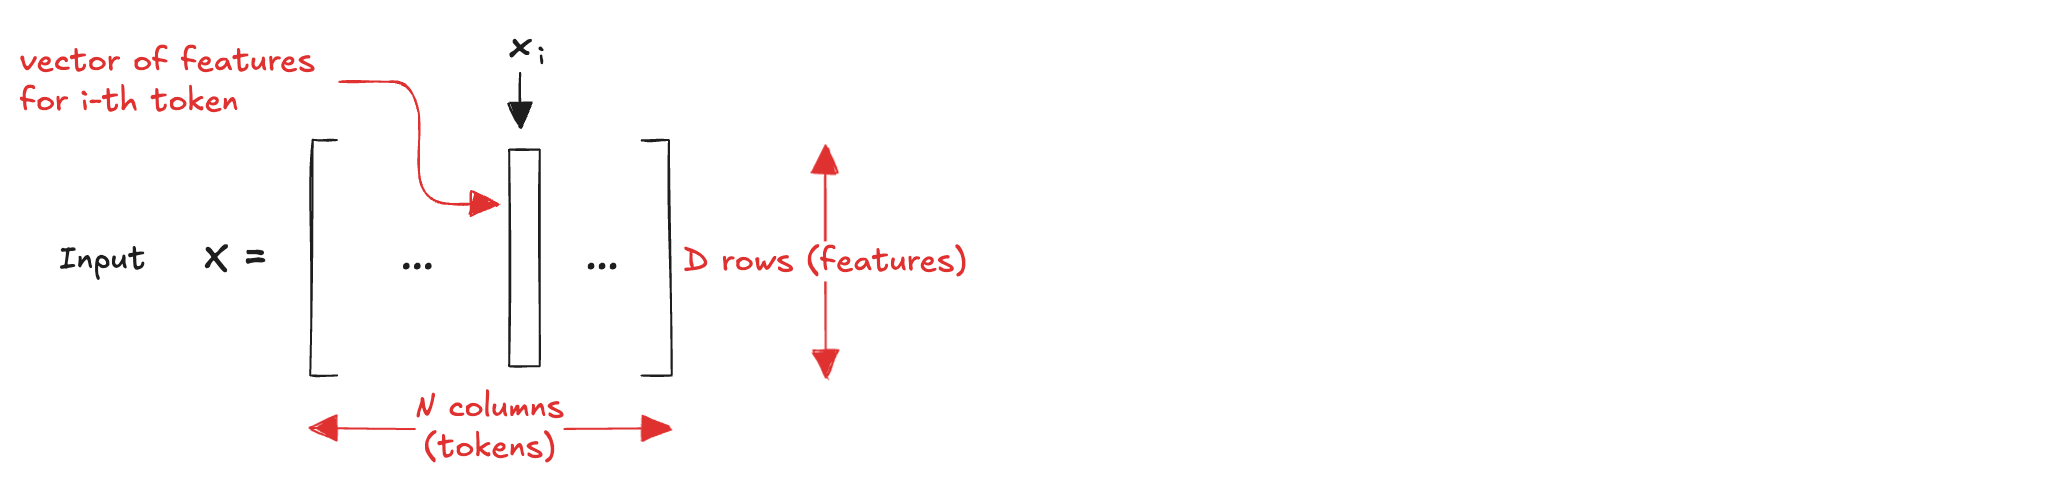

Although much of the literature adopts the transposed convention for X (NxD), thinking in terms of a DxN matrix is often conceptually clearer: each column is an element of a D-dimensional representation space, and the transformer processes a set (or sequence) of such vectors.

The transformation from raw data to this matrix of tokens is called **tokenisation**. Tokenisation is not a universal procedure: it depends on both the modality of the input and the objective of the task. In natural language processing, a sentence may be decomposed into words or subwords, each mapped to a vector: 

In computer vision, an image can be partitioned into non-overlapping patches, each patch flattened and projected into a vector:

In audio, one might segment the waveform into time frames or use spectral patches:

The key idea is always the same, **convert structured raw data into a collection of fixed-dimensional vectors**.

These vectors are called **embeddings**. They constitute the actual input processed by the transformer. Mathematically, an embedding maps a discrete or structured object into a continuous vector space. Conceptually, this space is organized so that tokens with **similar semantic** or **functional roles** are mapped to **nearby points**. In a language model, for instance, "king" and "queen" tend to lie close to each other in embedding space because they share contextual and semantic properties, whereas an unrelated word such as "dog" will typically be farther away. Embeddings can be p**redefined and kept fixed**, but in modern architectures they are usually **learned** jointly with the rest of the model parameters. For text, this means that word or subword vectors are optimized during training. For images, it typically means that each flattened patch is passed through a learned linear projection that maps it into the embedding space.


Prior to transformers, recurrent architectures (e.g.LSTM) were the state of the art in modeling sequential data. These architectures contain a feedback loop in the network connections that allows information to propagate from one step to another. An RNN receives some input, feeds it through the
network, and outputs a vector called the hidden state. At the same time, the model feeds some information back to itself through the feedback loop, which it can then use in the next step. This can be more clearly seen if we "unroll" the loop: 

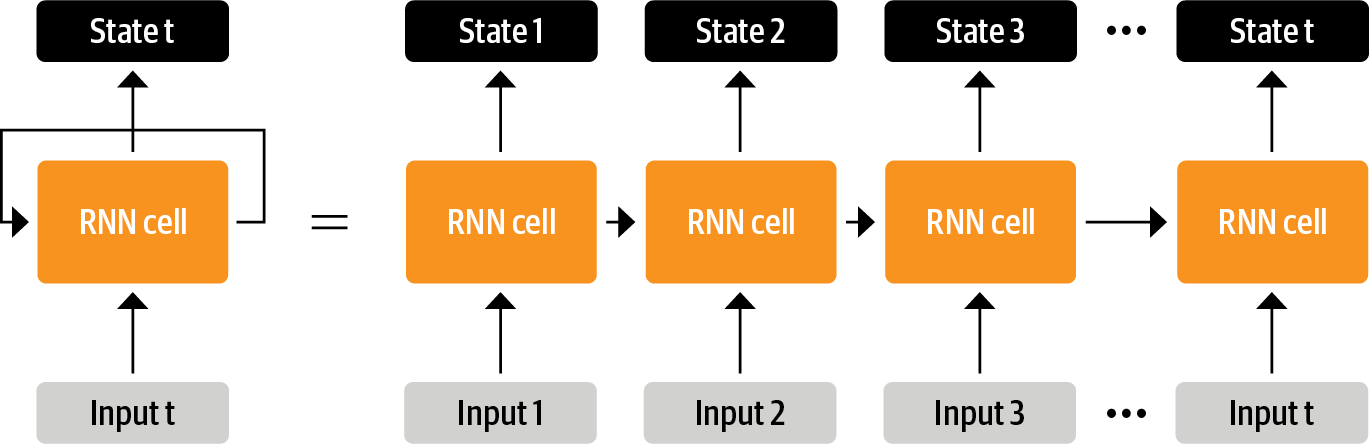

The RNN passes information about its state at each step to the next operation in the sequence. This allows an RNN to keep track of information from previous steps, and use it for its output predictions.

In situations where the input and output are both sequences of arbitrary length (e.g. text translation), a common approach is to use an **encoder-decoder architecture**. This consists of two separate RNNs: the encoder processes the input sequence and produces a vector representation, while the decoder takes this representation and generates the output sequence.
The job of the encoder is to encode the information from the input sequence into a numerical representation that is often called the last hidden state. This state is then passed to the decoder, which generates the output sequence.

XXX

For exmaple, we can use this architecture  where the English sentence “Transformers are great!” is encoded as a hidden state vector that is then decoded to produce the German translation “Transformer
sind grossartig!” The input words are fed sequentially through the encoder and the output words are generated one at a time, from top to bottom:

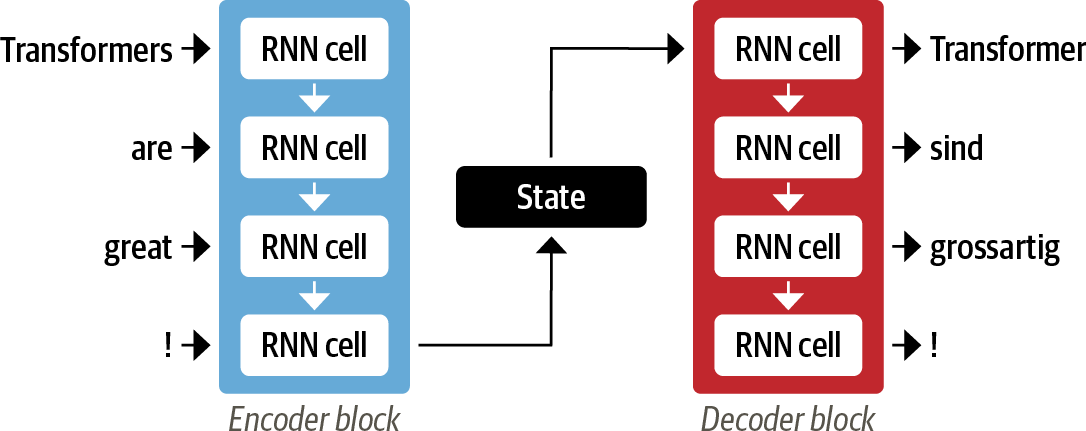

Although elegant in its simplicity, one weakness of this architecture is that the final hidden state of the encoder creates an **information bottleneck**: it has to represent the meaning of the whole input sequence because this is all the decoder has access to when generating the output. This is especially challenging for long sequences, where information at the start of the sequence might be lost in the process of compressing everything to a single, fixed representation.

Fortunately, there is a way out of this bottleneck by allowing the decoder to have access to all of the encoder’s hidden states. The general mechanism for this is called **attention**.

## Attention Mechanisms

The main idea behind attention is that instead of producing a single hidden state for the input sequence, the encoder outputs a hidden state at each step that the decoder can access. However, using all the states at the same time would create a huge input for the decoder, so some mechanism is needed to prioritize which states to use. This is where attention comes in: it lets the decoder assign a different amount of weight ("attention") to each of the encoder states at every decoding timestep:

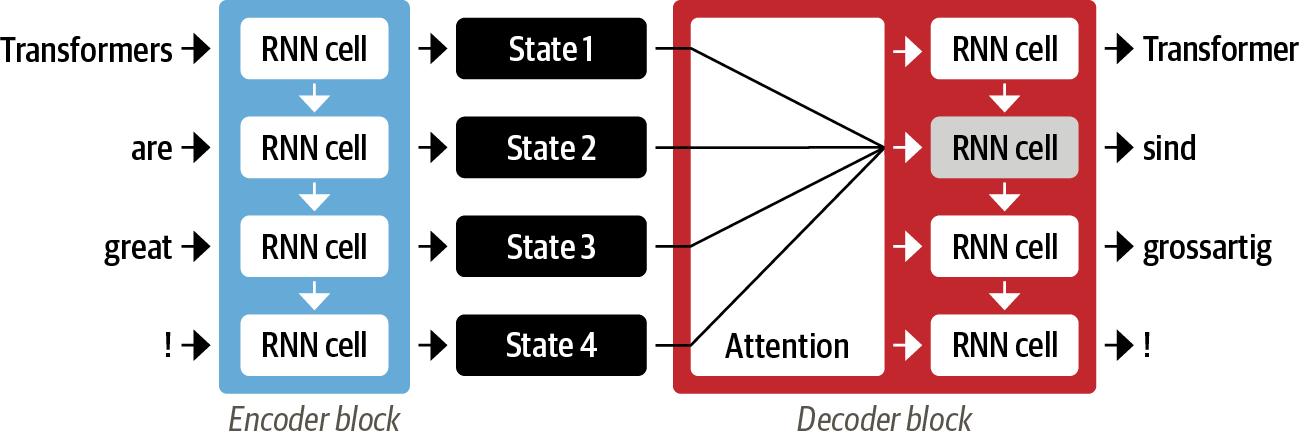

By focusing on which input tokens are most relevant at each timestep, these
attention-based models are able to learn nontrivial alignments between the words in a
generated translation and those in a source sentence. For example, Figure 1-5 visualizes
the attention weights for an English to French translation model, where each
pixel denotes a weight. The figure shows how the decoder is able to correctly align the
words “zone” and “Area”, which are ordered differently in the two languages:

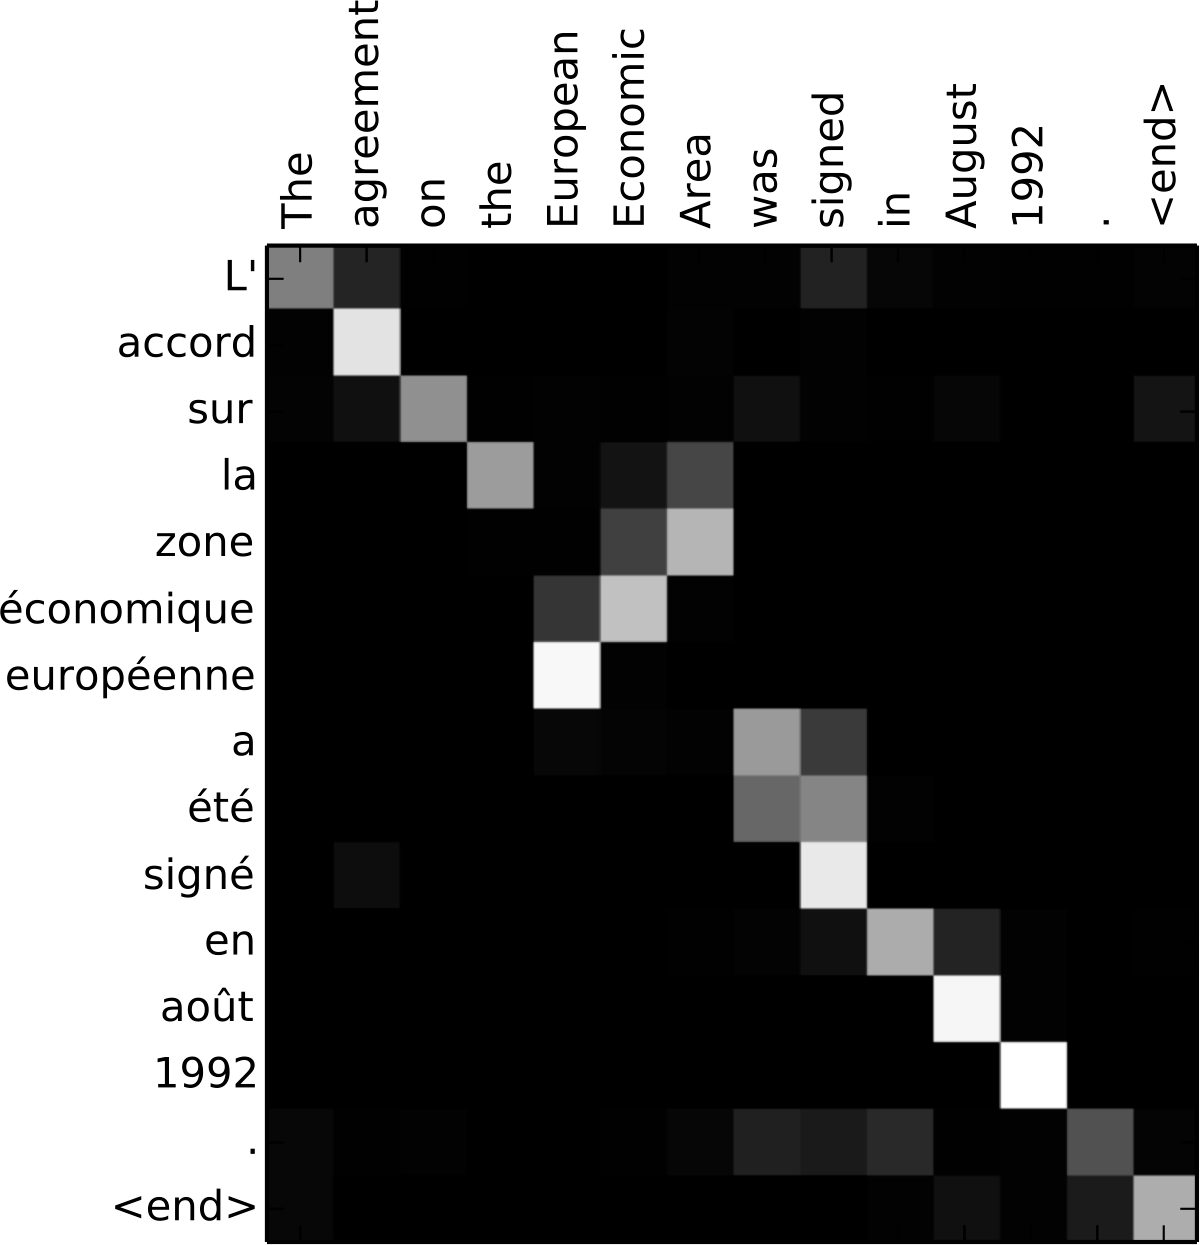

Although attention enabled the production of much better translations, there was still a major shortcoming with using recurrent models for the encoder and decoder: the computations are inherently sequential and cannot be parallelized across the input sequence.

With the transformer, a new modeling paradigm was introduced: dispense with recurrence altogether, and instead rely entirely on a special form of attention called self-attention. The basic idea
is to allow attention to operate on all the states in the same layer of the neural network.

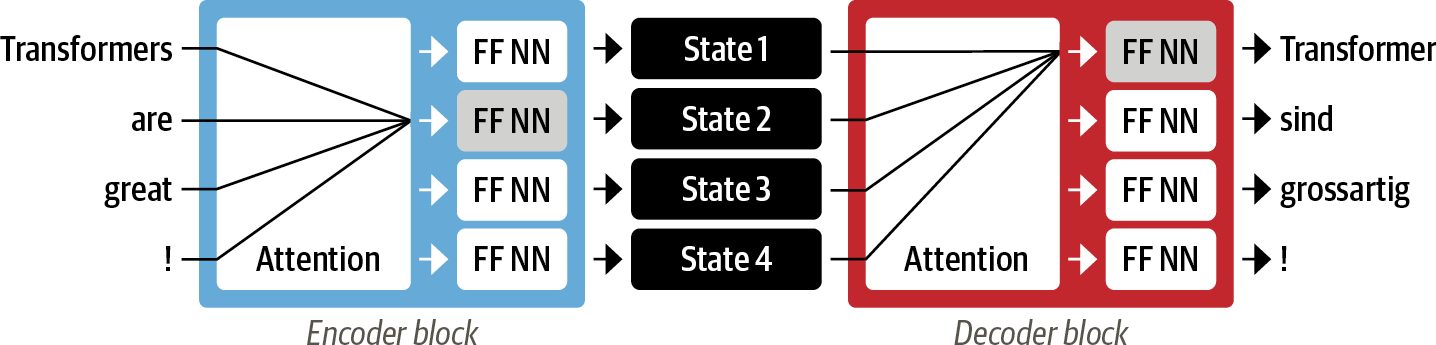

where both the encoder and the decoder have their
own self-attention mechanisms, whose outputs are fed to feed-forward neural networks
(FF NNs). This architecture can be trained much faster than recurrent models
and paved the way for many of the recent breakthroughs in NLP